# DFM Mixture Models with PyStan
I've adapted Dan Foreman-Mackey's [excellent blog](http://dfm.io/posts/mixture-models/) on utilising marginalised mixture models ([Hogg et al. 2010](http://adsabs.harvard.edu/abs/2010arXiv1008.4686H)) using emcee to PyStan, achieving similar results. 

The main difference is in the treatment of the posterior probability calculation and the treatment of the parameter transformations in STAN.

All code in this notebook that does not directly relate to the use of PyStan was writtenby Dan Foreman-Mackey in his blog, and the credit is his, not mine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
# We'll choose the parameters of our synthetic data.
# The outlier probability will be 80%:
true_frac = 0.8

# The linear model has unit slope and zero intercept:
true_params = [1.0, 0.0]

# The outliers are drawn from a Gaussian with zero mean and unit variance:
true_outliers = [0.0, 1.0]

# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)
x = np.sort(np.random.uniform(-2, 2, 15))
yerr = 0.2 * np.ones_like(x)
y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))

#Save the truth
truths = true_params + [true_frac, true_outliers[0], np.log(true_outliers[1])]

# Those points are all drawn from the correct model so let's replace some of
# them with outliers.
m_bkg = np.random.rand(len(x)) > true_frac
y[m_bkg] = true_outliers[0]
y[m_bkg] += np.sqrt(true_outliers[1]+yerr[m_bkg]**2) * np.random.randn(sum(m_bkg))

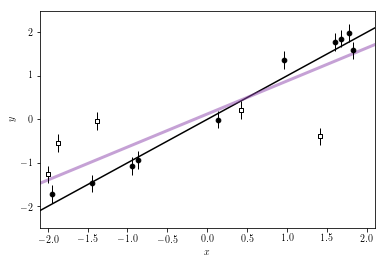

In [66]:
# First, fit the data and find the maximum likelihood model ignoring outliers.
A = np.vander(x, 2)
p = np.linalg.solve(np.dot(A.T, A / yerr[:, None]**2), np.dot(A.T, y / yerr**2))

# Then save the *true* line.
x0 = np.linspace(-2.1, 2.1, 200)
y0 = np.dot(np.vander(x0, 2), true_params)

# Plot the data and the truth.
plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c="w",edgecolor='k', zorder=1000)
plt.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c="k", zorder=1000)
plt.plot(x0, y0, color="k", lw=1.5)

# Plot the best fit line.
plt.plot(x0, x0 * p[0] + p[1], color="#8d44ad", lw=3, alpha=0.5)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2.5, 2.5)
plt.xlim(-2.1, 2.1);

In [25]:
#Now we have to put this through PyStan
import pystan
code = '''
data {
    int<lower = 0> N;
    real x[N];
    real y[N];
    real err[N];
}
parameters {
    real m;
    real b;
    real<lower=0, upper=1> Q;
    real M;
    real lnV;
}
transformed parameters{
    real line[N];
    real Vsig[N];
    for (i in 1:N)
        line[i] = m * x[i] + b;
    for (i in 1:N)
        Vsig[i] = err[i]^2 + exp(lnV);
}
model {
    m ~ normal(1., 0.9);
    b ~ normal(0., 0.9);
    Q ~ normal(0.5,.5);
    M ~ normal(0., 2.4);
    lnV ~ normal(-1.,4.);
    
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(y[n] | line[n], err[n]),
                    normal_lpdf(y[n] | M, Vsig[n]));
}
'''
sm = pystan.StanModel(model_code = code, model_name='dfmmm')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL dfmmm_8198efad4a7fae4c2eb70a40316c9c1c NOW.


In [26]:
#Load in the data
dat = {'N': len(x),
      'x': x,
      'y': y,
      'err':yerr}
fit = sm.sampling(data=dat, iter=1500, chains=32)

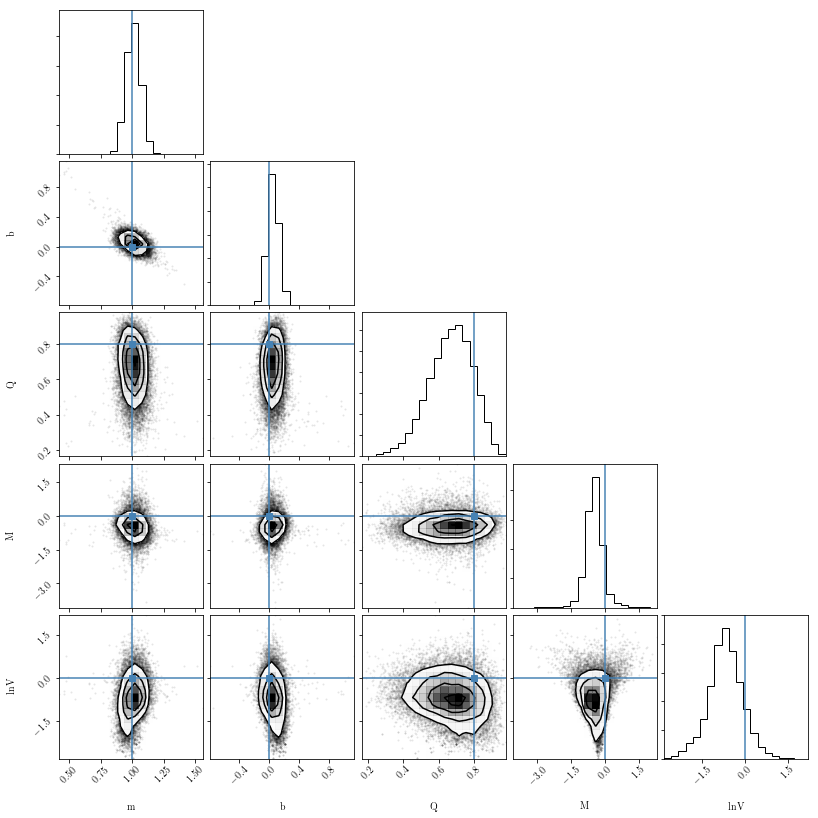

In [32]:
import corner
trace = fit.extract()
chain = np.array([trace['m'],trace['b'],trace['Q'],trace['M'],trace['lnV']])
corner.corner(chain.T,\
             labels=['m','b','Q','M','lnV'],\
             truths=truths)
plt.show()

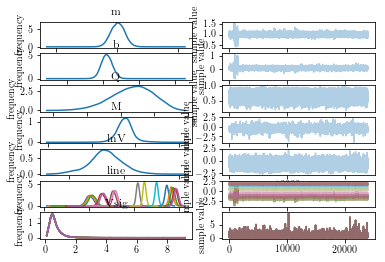

(5, 24000)

In [69]:
fit.plot()
plt.show()

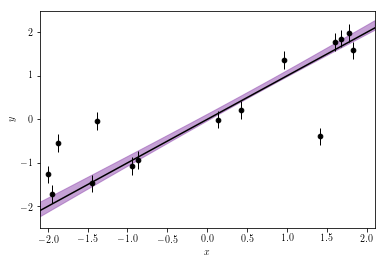

In [73]:
# Compute the quantiles of the predicted line and plot them.
A = np.vander(x0, 2)
lines = np.dot(chain.T[:,:2], A.T)
quantiles = np.percentile(lines, [16, 84], axis=0)
plt.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5)

# Plot the data.
plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
plt.scatter(x, y, marker="o", s=22, c="k", zorder=1000)

# Plot the true line.
plt.plot(x0, y0, color="k", lw=1.5)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2.5, 2.5)
plt.xlim(-2.1, 2.1);

In [34]:
#Lets define a normal distribution function for ease of access
def normal(x, mu, sigma2):
    N = (1/np.sqrt(2*np.pi*sigma2)) * np.exp(-(x - mu)**2 / (2*sigma2))
    return N

In [76]:
#We don't have access to blobs like we would with emcee, so we'll have to recalculate the likelihood functions
norm = 0.0
post_prob = np.zeros(len(x)) 
for n in range(trace['Q'].shape[0]):
    #Calculate the probability functions at this iteration n the hard way
    ll_fg = np.log(trace['Q'][n] * normal(y, trace['line'][n], yerr))
    ll_bg = np.log((1-trace['Q'][n]) * normal(y, trace['M'][n], trace['Vsig'][n]))
    
    #Calculate the posterior probability using log space
    post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
    norm += 1
post_prob /= norm

In [78]:
print(", ".join(map("{0:.3f}".format, post_prob)))

0.648, 0.905, 0.090, 0.882, 0.090, 0.815, 0.802, 0.792, 0.817, 0.965, 0.001, 0.987, 0.989, 0.991, 0.977


(-2.1, 2.1)

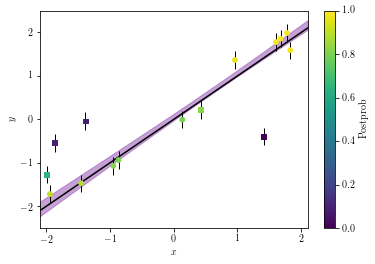

In [77]:
# Plot the predition.
plt.fill_between(x0, quantiles[0], quantiles[1], color="#8d44ad", alpha=0.5)

# Plot the data points.
plt.errorbar(x, y, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
# Plot the (true) outliers.
plt.scatter(x[m_bkg], y[m_bkg], marker="s", s=22, c=post_prob[m_bkg], cmap="viridis", vmin=0, vmax=1, zorder=1000)
# Plot the (true) good points.
plt.scatter(x[~m_bkg], y[~m_bkg], marker="o", s=22, c=post_prob[~m_bkg], cmap="viridis", vmin=0, vmax=1, zorder=1000)

# Plot the true line.
plt.plot(x0, y0, color="k", lw=1.5)

#Add a colorbar
plt.colorbar(c, label='Postprob')

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.ylim(-2.5, 2.5)
plt.xlim(-2.1, 2.1)